In [1]:
import boxx  
# boxx: A Tool-box for Efficient Build and Debug in Python. Especially for Scientific Computing and Computer Vision.
# For more infomation about boxx : https://github.com/DIYer22/boxx
import numpy as np
import pandas as pd 
import random
import os
import math
import glob
import io
from skimage.io import imread

In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch 
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import cv2

In [3]:
train_categories_df = pd.read_csv("train_categories_df.csv")
labels = train_categories_df.name

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretranined=True)
num_classes = len(labels) + 1 # one more for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [5]:
model.load_state_dict(torch.load('model_fasterrcnn.pt'))
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

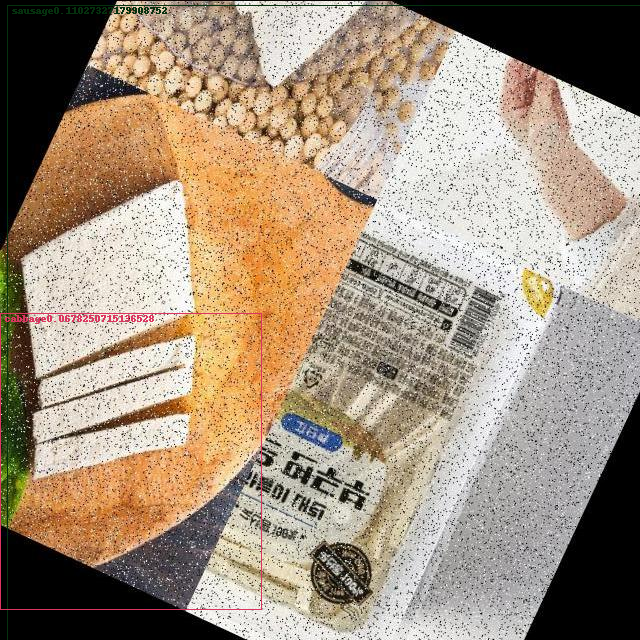

In [6]:
model.eval()
img_path = "try.jpg"
img = Image.open('images/try.jpg').convert('RGB')
img = T.ToTensor()(img)
output = model([img])
out_bbox = output[0]['boxes']
out_scores = output[0]['scores'].detach()
out_labels = output[0]['labels']
keep = torchvision.ops.nms(out_bbox, out_scores, 0.20)
out_bbox = out_bbox[keep]
out_scores = out_scores[keep]
out_labels = out_labels[keep]
out_labels_df = pd.DataFrame(out_labels,columns=['labels'])
out_classes = pd.DataFrame(list(out_labels_df.labels.apply(lambda x: train_categories_df.name[x])),columns=["category"])
im = (img.permute(1,2,0).cpu().detach().numpy() * 255).astype('uint8')

# image and bboxes with labels
import random

def random_color():
    return (random.randint(0,255), random.randint(0,255),random.randint(0,255)) 

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for b in range(len(out_bbox)):
    box = out_bbox[b]
    color = random_color()
    draw.rectangle(list(box), fill=None, outline=color)
    text = out_classes.category[b] + str(out_scores[b].item())
    # drawing text size
    draw.text((box[0]+5, box[1]), text, fill=color, align="right")   
vsample

In [7]:
preds_class = out_classes.category.unique()
preds_class

array(['sausage', 'cabbage'], dtype=object)